In [1]:
import numpy as np, csv, matplotlib.pyplot as plt, random
%matplotlib inline
from RBM_utils import Load_data, P_h_given_x, P_x_given_h, Persistent_Contrastive_Divergence, RBM_Initialize_Weights
from RBM_utils import RBM_cross_entropy_loss, display_data, free_energy, gibbs_hvh, gibbs_vhv,sampling_from_RBM, sigmoid

In [2]:
# ---------------Load & Visualize the training data------------------------
train_file_path = 'digitstrain.txt'
val_file_path = 'digitsvalid.txt'
test_file_path = 'digitstest.txt'
X_train, Y_train = Load_data(train_file_path)
X_val, Y_val = Load_data(val_file_path)
X_test, Y_test = Load_data(test_file_path)
print("Data Loaded...")
#display_data(X_train)

Data Loaded...


In [3]:
import pandas as pd
x = pd.DataFrame(X_train)
x = x.sample(frac=1)
X_train = np.array(x)

# Train RBM

In [4]:
#-------------------------------Network Architecture-----------------------
L_in = 784
L_hid = 100           # List Sizes of the hidden layer
CD_K = 1              # Steps for contrastive divergence
#----------------------------- Hyper Parameters -----------------------
epochmax = 10
LearningRate = 0.001
N = X_train.shape[0]
# --------------- Initializing Parameters------------------------
W = RBM_Initialize_Weights((L_in, L_hid))
#b = np.zeros((L_hid))
#c = np.zeros((L_in))
b = np.zeros((L_hid)) #Size 100
c = np.zeros((L_in))  #Size 784 

# ---------------Training RBM------------------------
J_train=[]
J_val = []
epoch=0

while epoch < epochmax:
    ep_arr=0
    np.random.shuffle(X_train)
    for k in range(X_train.shape[0]):
        x = X_train[k,:] #Needs to be of shape (3000x784 --> 1x784)
        h_mean, h_sample = P_h_given_x(W, b, x)
        #x_tilda = P_x_given_h(W, c, h )
        #----------------Update Weights-------------- until epochmax!
        #x_hat, h_hat = Contrastive_Divergence(x, W, b, c, k=CD_K)
        #W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h.reshape(1,L_hid)) -np.matmul(x_hat.reshape(L_in,1),h_hat.reshape(1,L_hid)))
        #b = b + LearningRate*np.mean((h - h_hat))
        #c = c + LearningRate*np.mean((x - x_hat))
        "[v1_mean, v1_sample, h1_mean, h1_sample] = gibbs_hvh(x, W, b, c, CD_K)"
        [v1_mean, v1_sample, h1_mean, h1_sample] = Persistent_Contrastive_Divergence(x, W, b, c, CD_K)
        W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h_sample.reshape(1,L_hid)) -
                              np.matmul(v1_sample.reshape(L_in,1),h1_sample.reshape(1,L_hid)))
        b = b + LearningRate*np.mean((h_sample - h1_sample))
        c = c + LearningRate*np.mean((x - v1_sample))

        J0 = RBM_cross_entropy_loss(x,v1_mean)
        ep_arr = ep_arr + J0

    J = ep_arr/X_train.shape[0]
    J_train.append(J)
    # Compute Validation Loss
    J1= 0
    for a in range(X_val.shape[0]):
        x_val = X_val[a,:]
        h_val_mean, h_val_sample = P_h_given_x(W, b, x_val)
        x_val_mean, x_val_sample = P_x_given_h(W, c, h_val_sample )
        J1 = J1 + RBM_cross_entropy_loss(x_val, x_val_mean)
    J1 = J1/a
    J_val.append(J1)
    print J, J1
    epoch = epoch+1
    #if epoch%50==1: LearningRate = LearningRate*0.5
    if epoch > 2 and abs(J_train[-2]-J) < 0.1 : LearningRate = LearningRate*0.5

270.455503934 177.968483805
188.130896789 157.371186803
167.726111324 148.327042135
158.961856803 142.545075606
153.232124561 138.08005828
149.520025261 134.846399103
146.037818128 132.102601429
143.467504291 130.027415577
141.095189829 127.911815295
139.745737238 126.151513086


In [5]:
RBM_trained_weights = [W, b, c]

In [7]:
import pickle
pickle.dump( RBM_trained_weights, open( "RBM_trained_weights.p", "wb" ) )

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

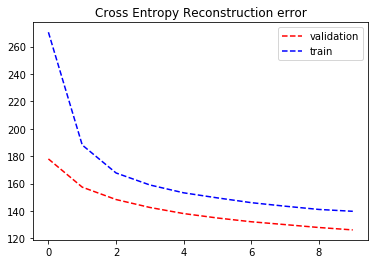

In [7]:
%matplotlib inline
plt.figure()
plt.plot(range(epochmax), J_val, '--r')
plt.plot(range(epochmax), J_train, '--b')
plt.legend(['validation','train'])
plt.title('Cross Entropy Reconstruction error')
#plt.savefig('RBM_Cross_Entropy_Reconstruction_error.png')

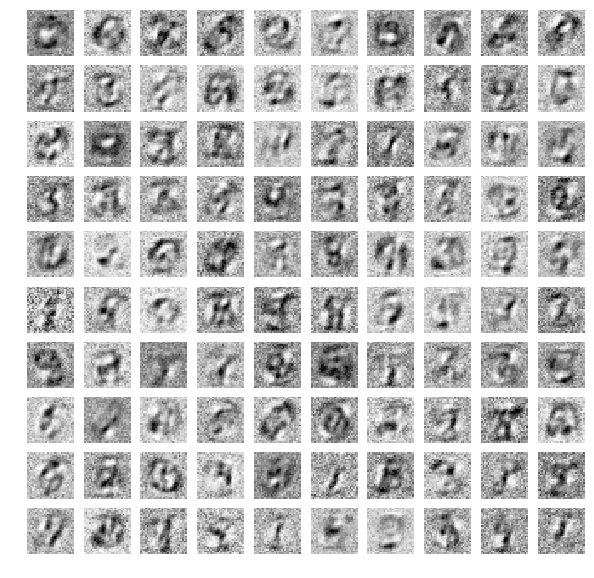

In [7]:
# Visualizing 1st layer weights:
fig = plt.figure(figsize=(10,10))
W1=W.reshape((28,28,100))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(W1[:,:,i-1].reshape((28,28)), cmap=plt.cm.Greys)
    ax.axis('off')
#plt.suptitle('Trained RBM Weights')
#plt.savefig('RBM_Trained_Weights.png')

# Sampling from RBM Model:

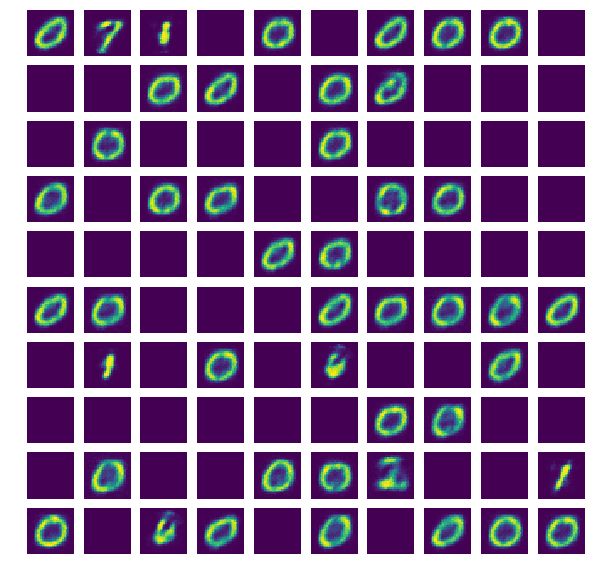

In [37]:
X_hats, X_probs = sampling_from_RBM(W, b, c, K=1000)

fig = plt.figure(figsize=(10,10))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(X_probs[i-1].reshape((28,28)))
    ax.axis('off')
#plt.suptitle('RBM Generated Images')
#plt.savefig('RBM_Generated_Images1.png')

# Comparing RBM with different k steps:

In [43]:
def RBM_k_step(CD_K = 1, LearningRate = 0.001):
     # Steps for contrastive divergence
    #-------------------------------Network Architecture-----------------------
    L_in = 784
    L_hid = 100           # List Sizes of the hidden layer
                 
    #----------------------------- Hyper Parameters -----------------------
    epochmax = 20
    LearningRate = LearningRate
    N = X_train.shape[0]
    # --------------- Initializing Parameters------------------------
    W = RBM_Initialize_Weights((L_in, L_hid))
    #b = np.zeros((L_hid))
    #c = np.zeros((L_in))
    b = np.zeros((L_hid)) #Size 100
    c = np.zeros((L_in))  #Size 784 

    # ---------------Training RBM------------------------
    J_train=[]
    J_val = []
    epoch=0

    while epoch < epochmax:
        ep_arr=0
        for k in range(X_train.shape[0]):
            x = X_train[k,:] #Needs to be of shape (3000x784 --> 1x784)
            h_mean, h_sample = P_h_given_x(W, b, x)
            #x_tilda = P_x_given_h(W, c, h )
            #----------------Update Weights-------------- until epochmax!
            #x_hat, h_hat = Contrastive_Divergence(x, W, b, c, k=CD_K)
            #W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h.reshape(1,L_hid)) -np.matmul(x_hat.reshape(L_in,1),h_hat.reshape(1,L_hid)))
            #b = b + LearningRate*np.mean((h - h_hat))
            #c = c + LearningRate*np.mean((x - x_hat))
            [v1_mean, v1_sample, h1_mean, h1_sample] = gibbs_hvh(x, W, b, c, CD_K)

            W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h_sample.reshape(1,L_hid)) -np.matmul(v1_sample.reshape(L_in,1),h1_sample.reshape(1,L_hid)))
            b = b + LearningRate*np.mean((h_sample - h1_sample))
            c = c + LearningRate*np.mean((x - v1_sample))

            J0 = RBM_cross_entropy_loss(x,v1_mean)
            ep_arr = ep_arr + J0

        J = ep_arr/X_train.shape[0]
        J_train.append(J)
        # Compute Validation Loss
        J1= 0
        for a in range(X_val.shape[0]):
            x_val = X_val[a,:]
            h_val_mean, h_val_sample = P_h_given_x(W, b, x_val)
            x_val_mean, x_val_sample = P_x_given_h(W, c, h_val_sample )
            J1 = J1 + RBM_cross_entropy_loss(x_val, x_val_mean)
        J1 = J1/a
        J_val.append(J1)
        print J, J1
        epoch = epoch+1
        #if epoch%50==1: LearningRate = LearningRate*0.5
        if epoch > 2 and abs(J_train[-2]-J) < 0.1 : LearningRate = LearningRate*0.5
    return(J_train, J_val)

In [39]:
(J_train_k5, J_val_k5) = RBM_k_step(CD_K = 5)

222.430907251 197.7390422
168.308032729 167.138818267
152.61900164 154.344377773
144.085587093 146.626147334
138.25761352 141.287662299
133.953423635 137.063507173
130.691904894 133.88944936
127.774726778 131.415732925
125.475306132 128.801212942
123.332527842 126.923000364
121.803895207 125.643644008
120.106129257 123.814421238
118.776383963 122.240110565
117.607217511 121.113881037
116.470631556 120.311336166
115.30758468 119.181738894
114.434332973 118.398962571
113.507163272 117.272413585
112.765966196 116.485913797
112.116877109 116.034260795


In [40]:
(J_train_k10, J_val_k10) = RBM_k_step(CD_K = 10)

223.502961776 198.427766456
168.725717706 167.549034678
152.726448856 154.726861466
144.232618233 146.713172043
138.484102182 141.653425496
134.245703479 137.539881107
130.676307529 133.97276304
128.14946478 132.012259603
125.799938182 129.600952222
123.685027446 127.323915815
122.026556935 125.544728792
120.385755003 124.176388958
118.978273353 122.734740836
117.58001326 121.557949826
116.546309956 120.353936245
115.465273304 119.401857673
114.616555086 118.550421766
113.601084418 117.570189092
112.959480177 116.607443118
112.11562779 116.272349311


In [46]:
(J_train_k20, J_val_k20) = RBM_k_step(CD_K = 20, LearningRate = 0.0005)

260.277256674 223.527074637
194.680455945 188.936930766
173.289143697 172.060401259
161.842362776 162.262194965
154.367390144 155.483006465
149.070921261 150.999809419
145.16659663 147.051602222
141.685841322 143.852938433
139.041941417 141.345144693
136.79358251 139.044701519
134.511565637 137.19111902
132.79514132 135.410726314
131.038233461 133.96250753
129.547927271 132.414379571
128.143525473 130.817039576
126.847649004 129.840539137
125.766822471 128.553969692
124.701009074 127.37689657
123.732567323 126.427438733
122.69340267 125.815475703


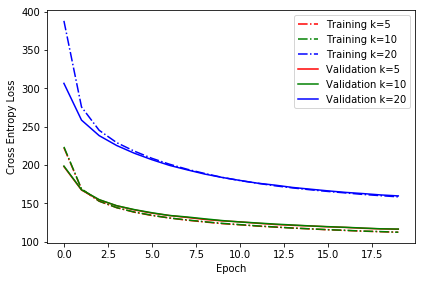

In [45]:
# Plotting convergence for k= 5,10,20
plt.figure()
plt.plot(range(len(J_train_k5))[0:50], J_train_k5[0:50], '-.r')
plt.plot(range(len(J_train_k10)), J_train_k10, '-.g')
plt.plot(range(len(J_val_k20)), J_train_k20, '-.b')

plt.plot(range(len(J_train_k5))[0:50], J_val_k5[0:50], 'r')
plt.plot(range(len(J_train_k10)), J_val_k10, 'g')
plt.plot(range(len(J_val_k20)), J_val_k20, 'b')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training k=5','Training k=10','Training k=20', 'Validation k=5','Validation k=10','Validation k=20'])
#plt.title('Validation Cross entropy')
plt.tight_layout()
#plt.savefig("Prob5b.png",dpi=200)

# Vary number of hidden units in the RBM

In [30]:
def RBM_hid_units(hid = 100):
    #-------------------------------Network Architecture-----------------------
    L_in = 784
    L_hid = hid           # List Sizes of the hidden layer
    CD_K = 1             # Steps for contrastive divergence
    #----------------------------- Hyper Parameters -----------------------
    epochmax = 20
    LearningRate = 0.001
    N = X_train.shape[0]
    # --------------- Initializing Parameters------------------------
    W = RBM_Initialize_Weights((L_in, L_hid))
    #b = np.zeros((L_hid))
    #c = np.zeros((L_in))
    b = np.zeros((L_hid)) #Size 100
    c = np.zeros((L_in))  #Size 784 

    # ---------------Training RBM------------------------
    J_train=[]
    J_val = []
    epoch=0

    while epoch < epochmax:
        ep_arr=0
        for k in range(X_train.shape[0]):
            x = X_train[k,:] #Needs to be of shape (3000x784 --> 1x784)
            h_mean, h_sample = P_h_given_x(W, b, x)
            #x_tilda = P_x_given_h(W, c, h )
            #----------------Update Weights-------------- until epochmax!
            #x_hat, h_hat = Contrastive_Divergence(x, W, b, c, k=CD_K)
            #W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h.reshape(1,L_hid)) -np.matmul(x_hat.reshape(L_in,1),h_hat.reshape(1,L_hid)))
            #b = b + LearningRate*np.mean((h - h_hat))
            #c = c + LearningRate*np.mean((x - x_hat))
            [v1_mean, v1_sample, h1_mean, h1_sample] = gibbs_hvh(x, W, b, c, CD_K)

            W = W + LearningRate*(np.matmul(x.reshape(L_in,1),h_sample.reshape(1,L_hid)) -np.matmul(v1_sample.reshape(L_in,1),h1_sample.reshape(1,L_hid)))
            b = b + LearningRate*np.mean((h_sample - h1_sample))
            c = c + LearningRate*np.mean((x - v1_sample))

            J0 = RBM_cross_entropy_loss(x,v1_mean)
            ep_arr = ep_arr + J0

        J = ep_arr/X_train.shape[0]
        J_train.append(J)
        # Compute Validation Loss
        J1= 0
        for a in range(X_val.shape[0]):
            x_val = X_val[a,:]
            h_val_mean, h_val_sample = P_h_given_x(W, b, x_val)
            x_val_mean, x_val_sample = P_x_given_h(W, c, h_val_sample )
            J1 = J1 + RBM_cross_entropy_loss(x_val, x_val_mean)
        J1 = J1/a
        J_val.append(J1)
        print J, J1
        epoch = epoch+1
        #if epoch%50==1: LearningRate = LearningRate*0.5
        if epoch > 2 and abs(J_train[-2]-J) < 0.1 : LearningRate = LearningRate*0.5
    return(J_train, J_val)

In [31]:
(J_train_h50, J_val_h50) = RBM_hid_units(hid = 50)

162.514805874 150.83613097
144.835213175 145.289347346
136.218412915 138.235457159
131.384319001 134.862029278
130.202263658 133.640217407
129.318279979 132.615474239
128.449077029 132.386671303
127.952065608 131.687239854
127.368026996 131.05171322
126.674734572 131.265685048
126.20306453 130.422303235
125.720846975 130.210446798
125.485742847 130.080173737
125.275684697 130.199644103
125.189220415 130.149723841
125.389235162 130.493969839
125.070203778 130.065959009
124.802607047 129.610628353
124.554696529 129.459708329
124.629902685 129.858070082
124.274405116 129.263174107
124.661451328 129.66283113
124.431175303 129.375677328
124.170232116 129.107300002
124.081137274 129.127956474
123.76958369 129.039396701
123.843379705 128.613654583
123.539131269 129.51590321
123.601941758 129.727885526
123.556576252 128.698806343
123.465603007 129.045669351
123.438357656 128.979390603
123.41823385 128.59485101
123.135232284 128.780702486
123.158457872 129.154906346
123.233087015 128.94461519
1

In [32]:
(J_train_h100, J_val_h100) = RBM_hid_units(hid = 100)

159.229375117 144.647792821
140.705446554 139.426757625
130.061469528 130.831943496
124.163911731 126.899995586
121.569944584 124.73360342
120.201946774 124.059773841
119.059746535 122.659497869
117.669539297 121.163079618
116.508572762 120.500894149
115.564246983 119.874485379
114.754917248 119.037523802
113.86186189 118.725615869
113.070163777 117.679374906
112.264432334 117.486423331
111.653207689 116.716701093
110.761810336 116.562376898
109.929764958 115.622919775
109.615611413 116.003585652
109.400123712 116.334419358
109.034184863 115.124064629
108.664643209 114.624573926
108.391270871 114.755481901
108.05306159 114.523990648
107.709807183 114.565614917
107.310019419 114.325421723
107.205821159 113.78581655
107.06365076 114.104780901
106.653878943 113.581221985
106.245026071 114.220591076
106.050094954 113.399494912
106.023718956 113.141582999
105.74949725 113.21088819
105.394973007 113.130820065
105.436666901 112.546885917
105.23543248 113.261594209
105.129813971 113.550814756


In [33]:
(J_train_h200, J_val_h200) = RBM_hid_units(hid = 200)

156.967614209 142.921508066
138.281616277 138.643538251
126.024228832 126.961485424
117.951242796 120.606428561
115.268265611 118.925829008
113.500564653 118.016529487
112.169428197 117.423335339
110.833694913 116.237314938
109.664968362 114.752881818
108.648977232 114.68201677
107.626895909 113.303738278
106.763925498 113.033438258
105.866288284 113.295019536
105.517305709 112.007617286
104.551745006 111.99458987
103.949469485 111.204403917
103.354571874 110.478034609
103.085554821 110.414297228
102.56344061 110.509280913
102.072939885 109.852820541
101.702747691 110.026981303
101.195319155 109.477477889
100.618035333 109.258817965
100.480873623 108.634639698
99.9787481219 109.355564859
99.9146698995 109.57235331
99.5667053922 108.228002298
98.8764724841 108.10590887
98.9162284542 108.133519014
98.7568673044 108.286572698
98.3504623889 108.538237411
98.1534792847 107.31917567
97.8402488767 107.870970466
97.6165184696 107.298088204
97.5273915711 108.003022888
97.470209493 107.132416758

In [34]:
(J_train_h500, J_val_h500) = RBM_hid_units(hid = 500)

155.895533926 141.327173175
136.347676949 136.912004778
122.619211624 123.717200314
114.331881906 117.75151505
111.273948728 116.34196363
109.702790289 114.845036858
107.639099201 113.186717441
106.312497131 112.105439705
105.084159496 111.614136944
104.037647724 110.077944883
102.748663345 110.33564587
101.894959133 110.108187658
101.038350713 108.789493582
100.228727197 108.391877495
99.4507158409 108.888198744
98.8130887843 107.605375279
98.3371636419 107.599683597
97.5428475076 107.394570851
97.1392212284 107.108351813
96.7499999084 106.731895958
96.3501550955 106.285536596
95.7350247382 106.028627873
95.5882898563 106.307234294
95.0417420298 105.469487689
94.7889811545 105.202202823
94.536812725 105.771278971
94.2356379208 105.271710653
93.6896151514 104.671626943
93.5596421703 105.891795913
93.4090221919 105.590409678
92.9549441086 104.883493932
92.7266355759 104.45313423
92.44522399 104.722180005
92.1047641259 104.192636814
91.7464108647 104.619938489
91.8234099417 104.323631152

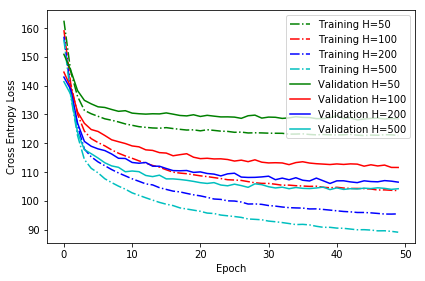

In [37]:
# Plotting convergence for k= 5,10,20
plt.figure()

plt.plot(range(len(J_train_h50)), J_train_h50, '-.g')
plt.plot(range(len(J_train_h100)), J_train_h100, '-.r')
plt.plot(range(len(J_train_h200)), J_train_h200, '-.b')
plt.plot(range(len(J_train_h500)), J_train_h500, '-.c')

plt.plot(range(len(J_val_h50)), J_val_h50, 'g')
plt.plot(range(len(J_val_h100)), J_val_h100, 'r')
plt.plot(range(len(J_val_h200)), J_val_h200, 'b')
plt.plot(range(len(J_val_h500)), J_val_h500, 'c')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training H=50','Training H=100','Training H=200','Training H=500', 
            'Validation H=50','Validation H=100','Validation H=200', 'Validation H=500'])
#plt.title('Validation Cross entropy')
plt.tight_layout()
plt.savefig("Prob5e_RBM.png",dpi=200)

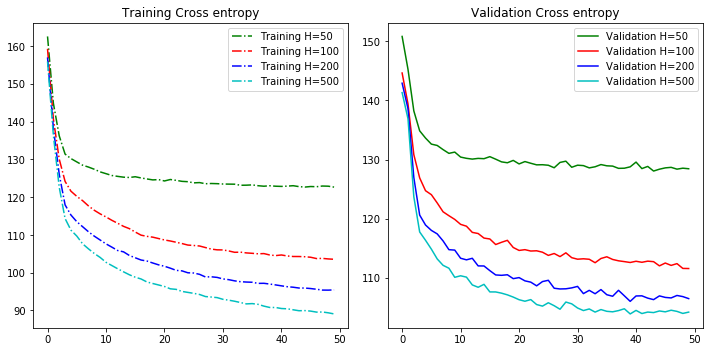

In [40]:
# Plotting convergence for k= 5,10,20
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range(len(J_train_h50)), J_train_h50, '-.g')
plt.plot(range(len(J_train_h100)), J_train_h100, '-.r')
plt.plot(range(len(J_train_h200)), J_train_h200, '-.b')
plt.plot(range(len(J_train_h500)), J_train_h500, '-.c')

plt.legend(['Training H=50','Training H=100','Training H=200','Training H=500'])
plt.title('Training Cross entropy')
plt.subplot(122)
plt.plot(range(len(J_val_h50)), J_val_h50, 'g')
plt.plot(range(len(J_val_h100)), J_val_h100, 'r')
plt.plot(range(len(J_val_h200)), J_val_h200, 'b')
plt.plot(range(len(J_val_h500)), J_val_h500, 'c')

plt.legend(['Validation H=50','Validation H=100','Validation H=200', 'Validation H=500'])
plt.title('Validation Cross entropy')
plt.tight_layout()
plt.savefig("Prob5e_RBM.png",dpi=200)

## Initialize and Train Neural Net: 1 layer with 100 hidden units

In [8]:
from utils import randInitializeWeights, Unroll_weights, Train_network, forward_prop, cross_entropy_loss
from utils import Tanh, TanhGradient, sigmoidGradient,sigmoid, ReLu, ReLuGradient, Mean_classification_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

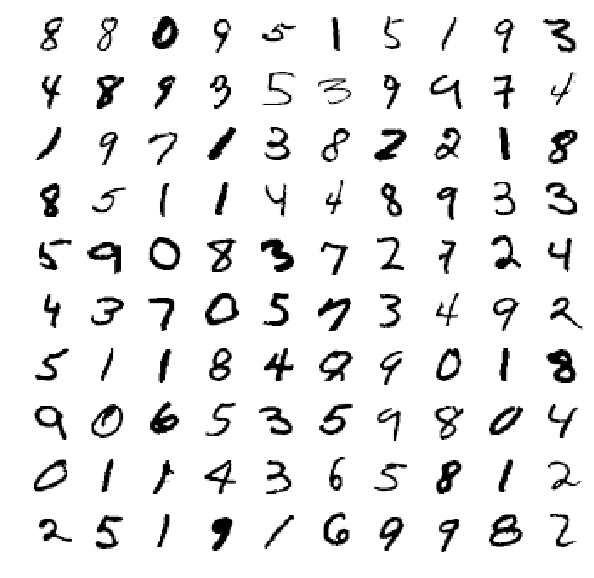

In [9]:
train_file_path = './digitstrain.txt'
val_file_path = './digitsvalid.txt'
test_file_path = './digitstest.txt'
# ---------------Load & Visualize the training data------------------------
X_train, Y_train = Load_data(train_file_path)
X_val, Y_val = Load_data(val_file_path)
X_test, Y_test = Load_data(test_file_path)
display_data(X_train)

In [10]:
print W.shape, b.shape, c.shape, W.T.shape

(784, 100) (100,) (784,) (100, 784)


## Pretrained neural net

In [ ]:
import pickle
RBM_trained_weights = pickle.load( open( "RBM_trained_weights.p", "rb" ) )
W, b, c = RBM_trained_weights

In [11]:
#-------------------------------Network Architecture-----------------------
n_hidden=1
input_layer_size=784
hidden_layer_size=[100]
num_labels = 10
layer_sizes=[input_layer_size]
layer_sizes.extend([hidden_layer_size[j] for j in range(len(hidden_layer_size))])
layer_sizes.append(num_labels)

# ----------------------------- Initializing Params------------------------
nn_weight_list = []
#RBM_trained_weights[0]--> W --> L_in x L_hid
#RBM_trained_weights[1]--> b --> #Size 100 L_hid
#RBM_trained_weights[2]--> c --> #Size 784 L_in
#W0 -- > L_out, 1 + L_in
for i in range(len(layer_sizes)-1):
    L_in = layer_sizes[i]
    L_out = layer_sizes[i+1]
    np.random.seed(0)
    if i==0:
        W = np.vstack((RBM_trained_weights[0],RBM_trained_weights[1])).T
    else:
        W = randInitializeWeights(L_in, L_out) #(100, 785)
    nn_weight_list.append(W)

""" The parameters for the neural network are "unrolled" into the vector nn_params
and need to be converted back into the weight matrices"""
nnparams = Unroll_weights(nn_weight_list, layer_sizes)

#------------------------------ Hyper Parameters ----------------------------
epochmax = 50
LearningRate = 0.01
reg_lambda = 0.0001
minibatchsize = 40            #Set =1 for regular stochastic gradient descent
momentum = 0.9
# -------------------------Set Activation Function----------------------------
activ_func = sigmoid
activ_Grad_func = sigmoidGradient

# ----------------------------Training Network--------------------------------
train_cost, val_cost, err_tr, err_val, nn_weight_list = Train_network(epochmax, reg_lambda, LearningRate, nnparams, layer_sizes, minibatchsize, momentum,  activ_func, activ_Grad_func, X_train, Y_train, X_val, Y_val)

Training Neural net....
('epochmax: 50', ' L2 Regularization: 0.000', ' Learning rate: 0.01', 'Momentum : 0.900', ' Layer Sizes', [784, 100, 10])
Time 0
Cross Entropy 	 Training:  0.747436276766 	 Validation:  0.829432575885
Mean  Error : 	 Training:  0.128333333333 	 Validation: 0.156
Time 10
Cross Entropy 	 Training:  0.162614290286 	 Validation:  0.476880119977
Mean  Error : 	 Training:  0.0166666666667 	 Validation: 0.085
Time 20
Cross Entropy 	 Training:  0.0605729722483 	 Validation:  0.430401338463
Mean  Error : 	 Training:  0.00133333333333 	 Validation: 0.077
Time 30
Cross Entropy 	 Training:  0.0312084667469 	 Validation:  0.422681088806
Mean  Error : 	 Training:  0.0 	 Validation: 0.08
Time 40
Cross Entropy 	 Training:  0.02031149909 	 Validation:  0.43117852815
Mean  Error : 	 Training:  0.0 	 Validation: 0.08


In [33]:
print('epochmax:{:3.0f}'.format(epochmax),' L2 Regularization: {:1.3f}'.format(reg_lambda),
  ' Learning rate: {:1.2f}'.format(LearningRate), ' Layer Sizes',layer_sizes)

# ---------------Printing Results------------------------
activations = forward_prop(layer_sizes, nn_weight_list, X_train, Y_train, activ_func)
output_p = activations[-1]
J_train= cross_entropy_loss(num_labels, output_p, Y_train, reg_lambda, nn_weight_list)
mean_err = Mean_classification_error(Y_train,output_p)
print 'Train', J_train, mean_err

activation_val = forward_prop(layer_sizes, nn_weight_list, X_val, Y_val, activ_func)
output_p = activation_val[-1]
J_val =  cross_entropy_loss(num_labels, output_p, Y_val, reg_lambda, nn_weight_list)
mean_err2 = Mean_classification_error(Y_val,output_p)
print 'Val',J_val, mean_err2

activation_test = forward_prop(layer_sizes, nn_weight_list, X_test, Y_test, activ_func)
output_p = activation_test[-1]
mean_err = Mean_classification_error(Y_test,output_p)
J_test =  cross_entropy_loss(num_labels, output_p, Y_test, reg_lambda, nn_weight_list)
print 'Test',J_test, mean_err
print "Test Performance is", 100.0*(1-mean_err),'%'


('epochmax: 50', ' L2 Regularization: 0.000', ' Learning rate: 0.01', ' Layer Sizes', [784, 100, 10])
Train 0.0150681194384 0.0
Val 0.440039124973 0.072
Test 0.513985075664 0.0826666666667
Test Performance is 91.7333333333 %


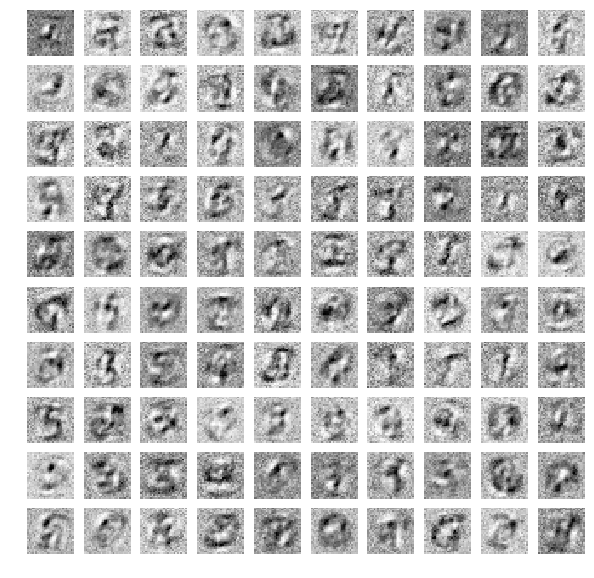

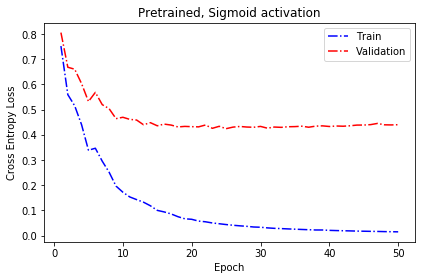

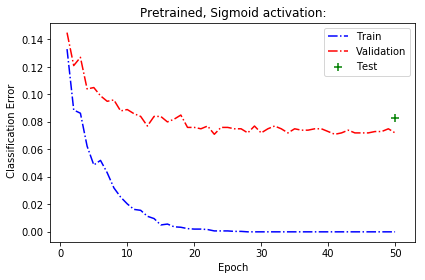

In [34]:
# ---------------Plotting Results------------------------
time = np.arange(epochmax/len(train_cost),epochmax+1,epochmax/len(train_cost))
fig = plt.figure(figsize=(10,10))
W = nn_weight_list[0][:,0:-1].reshape((100,28,28))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(W[i-1], cmap=plt.cm.Greys)
    ax.axis('off')
plt.savefig('NN_pretrained_weights.png',dpi = 200)
plt.show()

plt.figure()
plt.plot(time,train_cost,'b-.')
plt.plot(time,val_cost,'r-.')
plt.legend(['Train','Validation'])
plt.title('Pretrained, Sigmoid activation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.tight_layout()
plt.savefig('NN_pretrained_loss.png',dpi = 200)

plt.figure()
plt.plot(time,err_tr,'b-.')
plt.plot(time,err_val,'r-.')
plt.scatter(epochmax,mean_err,c='green',marker = '+',s = 80)
plt.legend(['Train','Validation','Test'])
plt.title('Pretrained, Sigmoid activation:')
plt.xlabel('Epoch')
plt.ylabel(' Classification Error')
plt.tight_layout()
plt.savefig('NN_pretrained_error.png',dpi = 200)
